# Radar observation : reflectivity composite of the new product

The aim of this notebook is to help you read the reflectivity data of the new product. These data range from 01/02/2018 to 31/12/18 included. The radar emits a signal which is reflected by the precipitation. "Reflectivity" is the amount of transmitted power returned to the radar receiver after hitting precipitation, compared to a reference power density at a distance of 1 meter from the radar antenna.

The new reflectivity product introduced the following changes :

* a new data processing algorithm 
  
* the reflectivity minimum detection threshold reduced from 8 to -9 dBZ

* the reflectivity values with a step of 0.5 dBZ

* 2 additionnal products : rain probability and selected measure height

For the radar new product, you will find one archive per year and per zone, each one sliced in periods of 10 or 11 days (each month is separated in 3 files). 

Each `.npz` file contains 5 arrays :

* `data` : an array containing reflectivity values (in 1/10 dBZ)

* `prob` : an array containing rain probability (in %)
  
* `height` : an array containing the selected measure height (in m)

* `dates` : an array containing a datetime object and indicating the date of each `data` map.

* `miss_dates` : an array containing a datetime object for each missing radar map over the period.

The '*non detection data*' value is -100 and the '*missing data*' value is -200.

In this notebook, a formula is provided to convert the dBz into mm.h<sup>-1</sup>.

For more information, cf [documentation](https://meteofrance.github.io/meteonet/english/data/rain-radar/).

# Quickstart

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import colors

First, let's select the zone and date we want to study : 

In [2]:
zone = "SE"    # NW or SE
year = 2018    # 2016, 2017 or 2018
month = 12
part_month = 2 # Choice between 1,2,3, as we said earlier each month is divided in 3 parts

Now, we load the data and the coordinates :

In [3]:
directory = "../../data_samples/radar/"
fname = directory + f'reflectivity_new_{zone}_{str(year)}_{str(month).zfill(2)}.{str(part_month)}.npz'
fname_coords = directory + f'radar_coords_{zone}.npz'

d = np.load(fname, allow_pickle=True)
data = d['data']
data[((data!=-200) & (data!=-100))] = data[((data!=-200) & (data!=-100))]/10      
prob = d['prob']
height = d['height']
dates = d['dates']
miss_dates = d['miss_dates']

coords = np.load(fname_coords, allow_pickle=True)
#it is about coordinates of the center of pixels 
lat = coords['lats']
lon = coords['lons']

Let's plot quickly the data :

<IPython.core.display.Javascript object>


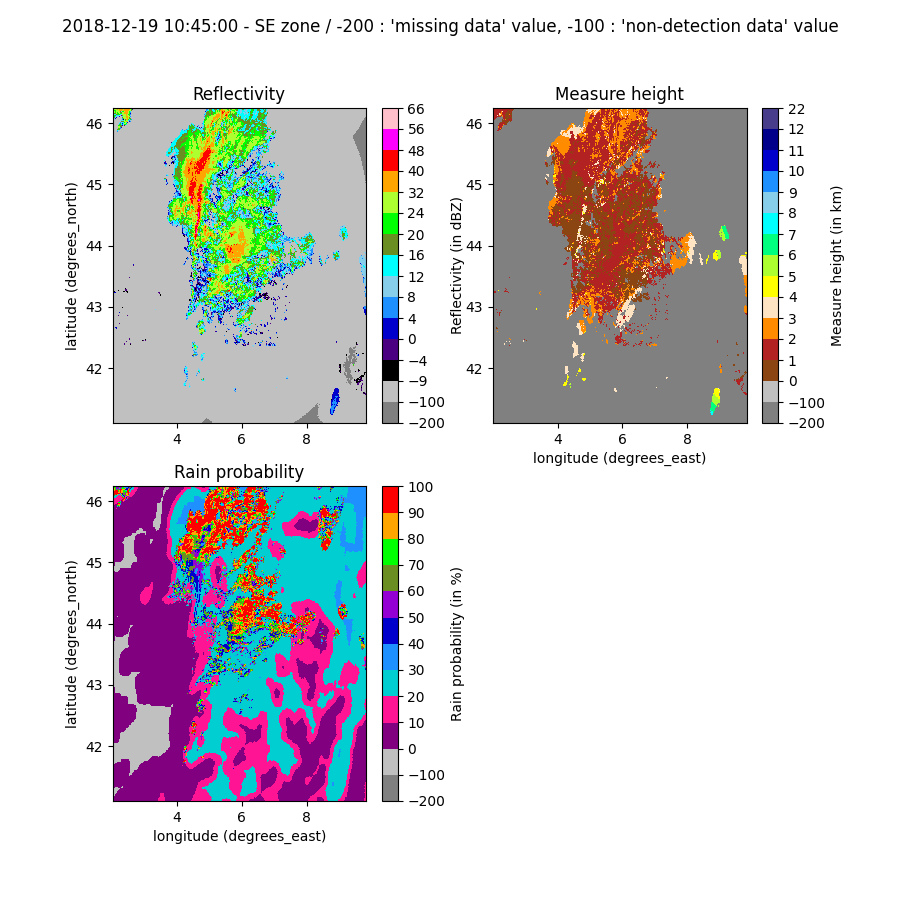

/opt/anaconda3/envs/preproc/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  
/opt/anaconda3/envs/preproc/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
/opt/anaconda3/envs/preproc/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
/opt/anaconda3/envs/preproc/lib/python3.7/site-package

In [4]:
index = 20
title = str(dates[index]) + " - "+  zone + " zone / -200 : 'missing data' value, -100 : 'non-detection data' value"

fig = plt.figure(figsize=(9,9))
gs = gridspec.GridSpec(2, 2, figure = fig)
fig.suptitle(title, fontsize=12)

# Reflectivity : colorbar definition
cmap = colors.ListedColormap(['gray','silver','black','indigo','mediumblue','dodgerblue', 'skyblue','cyan',
                              'olivedrab','lime','greenyellow','orange','red','magenta','pink'])
bounds = [-200,-100,-9,-4,0,4,8,12,16,20,24,32,40,48,56,66]
norm = colors.BoundaryNorm(bounds, cmap.N)
ax =  pl.subplot(gs[0, 0])    
p1=ax.pcolormesh(lon, lat, data[index],cmap=cmap, norm=norm)
ax.set_ylabel('latitude (degrees_north)')
ax.set_title("Reflectivity")
pl.colorbar(p1,ax=ax, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds, 
            orientation= 'vertical').set_label('Reflectivity (in dBZ)')

# Height 
height = d['height']
height_plot = height
height_plot[((height!=-200) & (height!=-100))] = height[((height!=-200) & (height!=-100))]/1000      
cmap = colors.ListedColormap(['gray','silver','saddlebrown','firebrick','darkorange','bisque','yellow','greenyellow',
                             'springgreen','cyan','skyblue','dodgerblue','mediumblue','darkblue','darkslateblue'])
bounds = [-200,-100,0,1,2,3,4,5,6,7,8,9,10,11,12,22]
norm = colors.BoundaryNorm(bounds, cmap.N)
ax =  pl.subplot(gs[0, 1])
p2=ax.pcolormesh(lon, lat, height_plot[index],cmap=cmap, norm=norm)
ax.set_xlabel('longitude (degrees_east)')
ax.set_title("Measure height")
pl.colorbar(p2,ax=ax, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds, orientation= 'vertical').set_label('Measure height (in km)')


# Rain Probability
cmap = colors.ListedColormap(['gray','silver','purple', 'deeppink','darkturquoise', 'dodgerblue','mediumblue','darkviolet','olivedrab'
                                  ,'lime','orange','red'])
bounds = [-200,-100,0,10,20,30,40,50,60,70,80,90,100]
norm = colors.BoundaryNorm(bounds, cmap.N)
ax =  pl.subplot(gs[1, 0])
p3=ax.pcolormesh(lon, lat, prob[index],cmap=cmap, norm=norm)
ax.set_ylabel('latitude (degrees_north)')
ax.set_xlabel('longitude (degrees_east)')
ax.set_title("Rain probability")
pl.colorbar(p3,ax=ax, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds, orientation= 'vertical').set_label('Rain probability (in %)')    

## Exploring the data

### Data

Dimensions of the ```data``` array: 

* Number of records : the radar records a scan every 5 min

* Number of points on the y axis : latitude

* Number of points on the x axis : longitude

In [ ]:
data.shape

### Dates

Dimension of the ```dates``` array: 

* Number of records : the radar records a scan every 5 min

In [ ]:
dates.shape

In [ ]:
dates

### Missing dates

Dimension of the ```miss_dates``` array: 

* Number of missing records

In [ ]:
miss_dates.shape

### Longitude

In [ ]:
lon.shape

In [ ]:
lon

# Plot with Cartopy

In [ ]:
from meteonet_toolbox.constant import DOMAINS
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [ ]:
# Coordinates of study zone boundaries
lllat=DOMAINS[zone]['lry']    #lower left latitude
urlat=DOMAINS[zone]['uly']    #upper right latitude
lllon=DOMAINS[zone]['ulx']    #lower left longitude
urlon=DOMAINS[zone]['lrx']    #upper right longitude
extent = [lllon, urlon, lllat, urlat]

Plot the different data for 1 given time step with a basemap

In [ ]:
index = 20
title = str(dates[index]) + " - "+  zone + " zone / -200 : 'missing data' value, -100 : 'non-detection data' value"

fig, axs = plt.subplots(3, figsize=(9,10), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle(title, fontsize=12)

# Reflectivity : colorbar definition
cmap = colors.ListedColormap(['gray','silver','black','indigo','mediumblue','dodgerblue', 'skyblue','cyan',
                              'olivedrab','lime','greenyellow','orange','red','magenta','pink'])
bounds = [-200,-100,-9,-4,0,4,8,12,16,20,24,32,40,48,56,66]
norm = colors.BoundaryNorm(bounds, cmap.N)
img = axs[0].imshow(data[index], cmap=cmap, norm=norm, extent=extent, origin = 'upper')
axs[0].coastlines(resolution='50m', linewidth=1)
axs[0].add_feature(cfeature.BORDERS.with_scale('50m'))
axs[0].set_ylabel('latitude (degrees_north)')
axs[0].set_title("Reflectivity")
plt.colorbar(img, ax=axs[0], cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds, 
             orientation= 'vertical').set_label('Reflectivity (in dBZ)')

# Height 
height = d['height']
height_plot = height
height_plot[((height!=-200) & (height!=-100))] = height[((height!=-200) & (height!=-100))]/1000      
cmap = colors.ListedColormap(['gray','silver','saddlebrown','firebrick','darkorange','bisque','yellow','greenyellow',
                             'springgreen','cyan','skyblue','dodgerblue','mediumblue','darkblue','darkslateblue'])
bounds = [-200,-100,0,1,2,3,4,5,6,7,8,9,10,11,12,22]
norm = colors.BoundaryNorm(bounds, cmap.N)
img = axs[1].imshow(height_plot[index],cmap=cmap, norm=norm, extent=extent, origin = 'upper')
axs[1].set_xlabel('longitude (degrees_east)')
axs[1].set_title("Measure height")
axs[1].coastlines(resolution='50m', linewidth=1)
axs[1].add_feature(cfeature.BORDERS.with_scale('50m'))
plt.colorbar(img, ax=axs[1], cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds, orientation= 'vertical').set_label('Measure height (in km)')


# # Rain Probability
cmap = colors.ListedColormap(['gray','silver','purple', 'deeppink','darkturquoise', 'dodgerblue','mediumblue','darkviolet','olivedrab'
                                  ,'lime','orange','red'])
bounds = [-200,-100,0,10,20,30,40,50,60,70,80,90,100]
norm = colors.BoundaryNorm(bounds, cmap.N)
img = axs[2].imshow(prob[index], cmap=cmap, norm=norm, extent=extent, origin = 'upper')
axs[2].set_ylabel('latitude (degrees_north)')
axs[2].set_xlabel('longitude (degrees_east)')
axs[2].set_title("Rain probability")
axs[2].coastlines(resolution='50m', linewidth=1)
axs[2].add_feature(cfeature.BORDERS.with_scale('50m'))
plt.colorbar(p3,ax=axs[2], cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds, orientation= 'vertical').set_label('Rain probability (in %)')  

# Convert dBZ into mm/h

In [ ]:
#multiplication coefficient for the graphic representation of rainfall rate (in 1/coeff mm/h)
#/!\### the colorbar is adapted to the coefficient 10 (cf plot at the end)
coeff = 10   
ind = 20

In [ ]:
##from dBZ to mm/h : Marshall-Palmer formula
a = 200
b = 1.6

rr = np.zeros((data.shape[0],data.shape[1],data.shape[2]))
rr[((data==-200) | (data==-100))]=np.nan
rr[((data!=-200) & (data!=-100))] = (10**(data[((data!=-200) & (data!=-100))]/10)/a)**(1/b)

rr_plot = coeff*rr

In [ ]:
def plot_mmh(rr_plot,coeff,ind, lat,lon, title = "4 examples of rainfall rate plots"):
    fig, ax = plt.subplots(2, 2,figsize=(9,9))
    fig.suptitle(title, fontsize=16)
    
    #colorbar definition
    #/!\### the scale is adapted to the coefficient 10
    if (np.nanmax(rr_plot) > 3646):
        borne_max = np.nanmax(rr_plot)
    else:
        borne_max = 3646 + 10
    cmap = colors.ListedColormap(['white', 'darkslateblue', 'mediumblue','dodgerblue', 'skyblue','olive','mediumseagreen'
                                      ,'cyan','lime','yellow','khaki','burlywood','orange','brown','red'])
    bounds = [0,2,4,6,12,21,36,65,115,205,365,648,1153,2050,3646,borne_max]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    pl=ax[0,0].pcolormesh(lon, lat, rr_plot[ind,:,:],cmap=cmap, norm=norm)
    ax[0,0].set_ylabel('latitude (degrees_north)')
    ax[0,0].set_title(str(dates[ind]) + " - "+  zone + " zone")

    pl=ax[0,1].pcolormesh(lon, lat, rr_plot[ind+1,:,:],cmap=cmap, norm=norm)
    ax[0,1].set_title(str(dates[ind+1]) + " - "+  zone + " zone")

    pl=ax[1,0].pcolormesh(lon, lat, rr_plot[ind+2,:,:],cmap=cmap, norm=norm)
    ax[1,0].set_xlabel('longitude (degrees_east)')
    ax[1,0].set_ylabel('latitude (degrees_north)')
    ax[1,0].set_title(str(dates[ind+2]) + " - "+  zone + " zone")

    pl=ax[1,1].pcolormesh(lon, lat, rr_plot[ind+3,:,:],cmap=cmap, norm=norm)
    ax[1,1].set_xlabel('longitude (degrees_east)')
    ax[1,1].set_title(str(dates[ind+3]) + " - "+  zone + " zone")

    cbar = fig.colorbar(pl,ax=ax.ravel().tolist(),cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds, orientation= 'vertical').set_label('Rainfall rate (in 1/10 mm/h) / nan : missing values')
    plt.show()

In [ ]:
#/!\ these function works only if there are at least 3 dates later than this chosen for the plot with Cartopy (ind variable, cf second cell)
plot_mmh(rr_plot,coeff,ind,lat,lon)

In [ ]:
data_plot = coeff*rr

fig = plt.figure(figsize=(9,5))

# Select projection
ax = plt.axes(projection=ccrs.PlateCarree())

#colorbar definition
#/!\### the scale is adapted to the coefficient 10
if (np.nanmax(data_plot) > 3646):
    borne_max = np.nanmax(data_plot)
else:
    borne_max = 3646 + 10
cmap = colors.ListedColormap(['white', 'darkslateblue', 'mediumblue','dodgerblue', 'skyblue','olive','mediumseagreen'
                                  ,'cyan','lime','yellow','khaki','burlywood','orange','brown','red'])
bounds = [0,2,4,6,12,21,36,65,115,205,365,648,1153,2050,3646,borne_max]
norm = colors.BoundaryNorm(bounds, cmap.N)

#plot the data and the background map (coastlines and borders)
img = ax.imshow(data_plot[ind,:,:], interpolation='none', origin='upper',cmap=cmap, norm=norm, extent=extent)
ax.coastlines(resolution='50m', linewidth=1)
ax.add_feature(cfeature.BORDERS.with_scale('50m'))

plt.colorbar(img, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds, orientation= 'horizontal').set_label('Rainfall rate (in 1/10 mm/h) / nan : missing values')
plt.title("Rainfall rate - "+ str(dates[ind]) + " - "+  zone + " zone")
plt.show()